<a href="https://colab.research.google.com/github/bam098/plant_pathology/blob/main/bam098_plant_pathology_v8_cln.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Pathology

Kaggle Competition: https://www.kaggle.com/c/plant-pathology-2020-fgvc7/data

In [ ]:
! pip uninstall fastai -y
! pip install fastai

Uninstalling fastai-1.0.61:
  Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 194kB 7.8MB/s 
     |████████████████████████████████| 61kB 5.0MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import platform
import fastai
from fastai.vision.all import *
import sklearn
from sklearn.metrics import roc_auc_score
import torch
import torchvision
import pandas as pd

print('python version:      {}'.format(platform.python_version()))
print('fastai version:      {}'.format(fastai.__version__))
print('sklearn version:     {}'.format(sklearn.__version__))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('pandas version:      {}'.format(pd.__version__))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.6.9
fastai version:      2.1.8
sklearn version:     0.22.2.post1
torch version:       1.7.0+cu101
torchvision version: 0.8.1+cu101
pandas version:      1.1.4
CUDA available:      True
cuDNN enabled:       True
num gpus:            1
gpu:                 Tesla T4

------------------------- CUDA -------------------------
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
random_seed = 42

labels = ['healthy', 'multiple_diseases', 'rust', 'scab']
data_dir = Path('/content/gdrive/MyDrive/fastai/data/plant-pathology')
img_dir  = data_dir / 'images'

img_size = 600
bs = 25
arch = densenet121
lr = 1e-2

In [ ]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)

#torch.backends.cudnn.benchmark = False
#torch.backends.cudnn.deterministic = True
#torch.set_deterministic(True)

## Data

In [ ]:
data_dir.ls()

(#4) [Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/train.csv'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/test.csv'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/sample_submission.csv'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images')]

In [ ]:
img_dir.ls()

(#3642) [Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1702.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1712.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_171.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1710.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1738.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1736.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1771.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1770.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1765.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1756.jpg')...]

### Explore Data

In [ ]:
train_df = pd.read_csv(data_dir/'train.csv'); train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


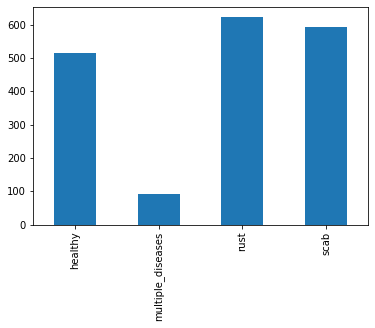

In [ ]:
train_df[labels].sum().plot(kind='bar')

### Load Data

In [ ]:
train_df['label'] = train_df[labels].idxmax(1); train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,scab
1,Train_1,0,1,0,0,multiple_diseases
2,Train_2,1,0,0,0,healthy
3,Train_3,0,0,1,0,rust
4,Train_4,1,0,0,0,healthy


In [ ]:
train_df['label'].value_counts()

rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: label, dtype: int64

In [ ]:
# oversampling, ref: https://www.kaggle.com/lextoumbourou/plant-pathology-2020-eda-training-fastai2?scriptVersionId=33070763

train_df_bal = pd.concat(
    [train_df.query('label != "multiple_diseases"'), train_df] +
    [train_df.query('label == "multiple_diseases"')] * 2
).sample(frac=1.0, random_state=random_seed).reset_index(drop=True)

In [ ]:
train_df_bal['label'].value_counts()

rust                 1244
scab                 1184
healthy              1032
multiple_diseases     273
Name: label, dtype: int64

In [ ]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock()), 
    getters=[ColReader('image_id', pref=img_dir, suff='.jpg'), ColReader('label')], 
    splitter=RandomSplitter(valid_pct=0.1, seed=random_seed),
    item_tfms=Resize(img_size),
    batch_tfms=aug_transforms(size=img_size, max_rotate=30., min_scale=0.75, flip_vert=True, do_flip=True)
)

In [ ]:
dls = db.dataloaders(source=train_df_bal, bs=bs)

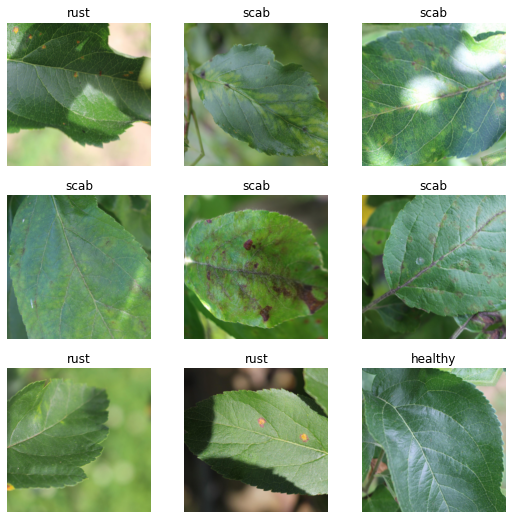

In [ ]:
dls.show_batch()

## Metric

In [ ]:
# AUC metric, ref: https://www.kaggle.com/lextoumbourou/plant-pathology-2020-eda-training-fastai2?scriptVersionId=33070763

def comp_metric(preds, targs, labels=range(len(labels))):
    # One-hot encode targets
    targs = np.eye(4)[targs]
    return np.mean([roc_auc_score(targs[:,i], preds[:,i]) for i in labels])

def healthy_roc_auc(*args):
    return comp_metric(*args, labels=[0])

def multiple_diseases_roc_auc(*args):
    return comp_metric(*args, labels=[1])

def rust_roc_auc(*args):
    return comp_metric(*args, labels=[2])

def scab_roc_auc(*args):
    return comp_metric(*args, labels=[3])

## Training

In [ ]:
learn = cnn_learner(
    dls, arch, 
    loss_func=LabelSmoothingCrossEntropy(),
    metrics=[accuracy, AccumMetric(comp_metric, flatten=False)]
).to_fp16()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.006918309628963471, lr_steep=9.12010818865383e-07)

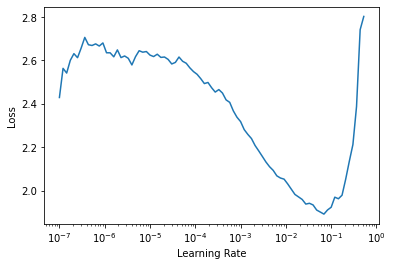

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(6, lr)

epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,1.024765,0.740069,0.825737,0.944825,04:29
1,0.757973,0.562151,0.927614,0.948189,03:55
2,0.704518,0.603394,0.938338,0.958511,03:54
3,0.589309,0.480494,0.941019,0.987183,03:54
4,0.507844,0.425082,0.983914,0.997463,03:55
5,0.478649,0.404797,0.986595,0.998461,03:55


In [ ]:
learn.save('stage-1')

Path('models/stage-1.pth')

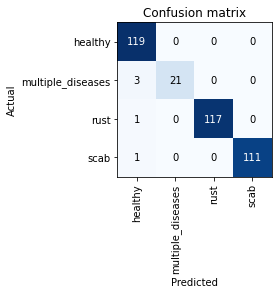

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

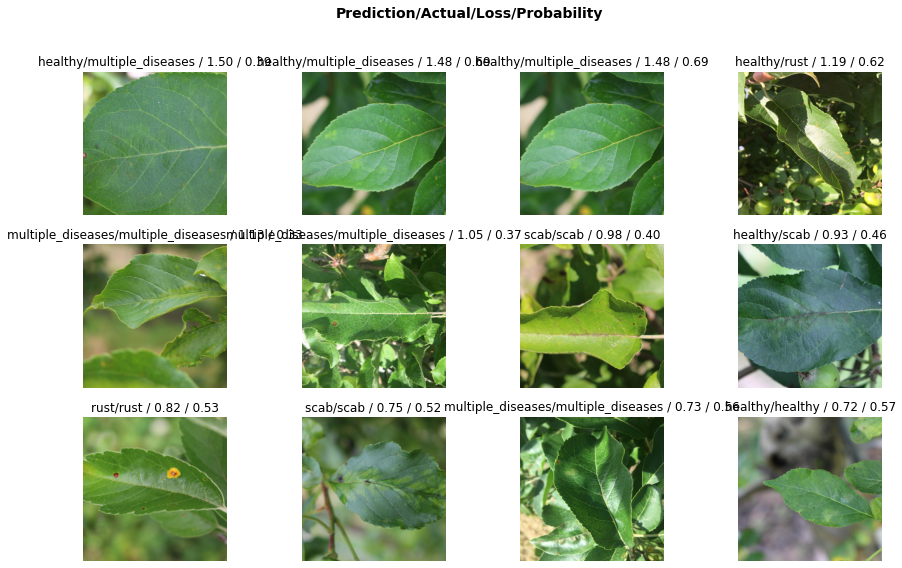

In [ ]:
interp.plot_top_losses(12, figsize=(15,9), nrows=3)

## Submission

In [ ]:
test_df = pd.read_csv(data_dir/'test.csv')
test_dl = dls.test_dl(test_df)

In [ ]:
test_preds, _ = learn.get_preds(dl=test_dl)

In [ ]:
sub_df = pd.concat([test_df, pd.DataFrame(test_preds, columns=labels)], axis=1)

In [ ]:
sub_df

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.058090,0.047830,0.873438,0.020642
1,Test_1,0.028630,0.020421,0.929756,0.021193
2,Test_2,0.019601,0.015708,0.010512,0.954179
3,Test_3,0.962088,0.005128,0.023516,0.009268
4,Test_4,0.028701,0.023277,0.931150,0.016872
...,...,...,...,...,...
1816,Test_1816,0.021256,0.012496,0.943500,0.022748
1817,Test_1817,0.026777,0.044603,0.026595,0.902025
1818,Test_1818,0.024937,0.014949,0.935766,0.024348
1819,Test_1819,0.979702,0.007605,0.009094,0.003600


In [ ]:
! pip uninstall -y kaggle
! pip install kaggle

Uninstalling kaggle-1.5.9:
  Successfully uninstalled kaggle-1.5.9
     |████████████████████████████████| 61kB 4.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=7b618f4107f22f0ded46b297a88e07243332f16ec9b56abcfb4a22f677b3cf21
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle


In [ ]:
! cp -r /content/gdrive/My\ Drive/.kaggle/ /root/

In [ ]:
! kaggle -v

Kaggle API 1.5.10


In [ ]:
sub_df.to_csv('submission.csv', index=False)

In [ ]:
! head -n 5 submission.csv

image_id,healthy,multiple_diseases,rust,scab
Test_0,0.058089703,0.047829974,0.8734385,0.020641848
Test_1,0.028629955,0.020420982,0.9297561,0.02119303
Test_2,0.019601319,0.015707862,0.010512343,0.9541785
Test_3,0.9620882,0.005128079,0.023515984,0.009267634


In [ ]:
! kaggle competitions submit plant-pathology-2020-fgvc7 -f submission.csv -m "v8pre2"

100% 97.5k/97.5k [00:01<00:00, 55.8kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7